https://medium.com/@fractaldle/guide-to-build-faster-rcnn-in-pytorch-95b10c273439

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F 
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torchvision
from torchvision.models.vgg import model_urls

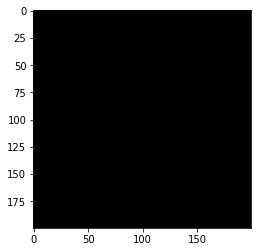

In [39]:
image = torch.zeros((1, 3, 200, 200)).float()

bbox = torch.FloatTensor([[20, 30, 50, 50], [120, 120, 180, 190]]) # [y1, x1, y2, x2] format
labels = torch.LongTensor([6, 8]) # 0 represents background
sub_sample = 4

plt.imshow(image[0].transpose(2, 0))

In [28]:
dummy_img = torch.zeros((1, 3, 200, 200)).float()
print(dummy_img.shape)

torch.Size([1, 3, 200, 200])


In [29]:
model_urls['vgg16'] = model_urls['vgg16'].replace('https://', 'http://')
model = torchvision.models.vgg16(pretrained=True)
fe = list(model.features)

In [30]:
fe

[Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace),
 

In [32]:
req_features = []
k = dummy_img.clone()
for i in fe:
    print(i)
    k = i(k)
    print(k.shape)
    print(k.size())
    if k.size()[2] < 200//4:
        break
    req_features.append(i)
    out_channels = k.size()[1]
print(len(req_features)) #30
print(out_channels) # 512

Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 64, 200, 200])
torch.Size([1, 64, 200, 200])
ReLU(inplace)
torch.Size([1, 64, 200, 200])
torch.Size([1, 64, 200, 200])
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 64, 200, 200])
torch.Size([1, 64, 200, 200])
ReLU(inplace)
torch.Size([1, 64, 200, 200])
torch.Size([1, 64, 200, 200])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
torch.Size([1, 64, 100, 100])
torch.Size([1, 64, 100, 100])
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 128, 100, 100])
torch.Size([1, 128, 100, 100])
ReLU(inplace)
torch.Size([1, 128, 100, 100])
torch.Size([1, 128, 100, 100])
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
torch.Size([1, 128, 100, 100])
torch.Size([1, 128, 100, 100])
ReLU(inplace)
torch.Size([1, 128, 100, 100])
torch.Size([1, 128, 100, 100])
MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=

In [33]:
faster_rcnn_fe_extractor = nn.Sequential(*req_features)
faster_rcnn_fe_extractor

Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace)
)

In [34]:
out_map = faster_rcnn_fe_extractor(image)
print(out_map.size())

torch.Size([1, 256, 50, 50])


# Anchor boxes

We will use anchor_scales of 8, 16, 32, ratio of 0.5, 1, 2 and sub sampling of 16 (Since we have pooled our image from 200 px to 50px). Now every pixel in the output feature map maps to corresponding 4 * 4 pixels in the image. This is shown in the below image

In [37]:
ratios = [0.5, 1, 2]
anchor_scales = [8, 16, 32]

anchor_base = np.zeros((len(ratios) * len(anchor_scales), 4), dtype=np.float32)

print(anchor_base)

[[0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]
 [0. 0. 0. 0.]]


In [40]:
ctr_y = sub_sample / 2.
ctr_x = sub_sample / 2.

print(ctr_y, ctr_x)

2.0 2.0


In [41]:
for i in range(len(ratios)):
    for j in range(len(anchor_scales)):
        h = sub_sample * anchor_scales[j] * np.sqrt(ratios[i])
        w = sub_sample * anchor_scales[j] * np.sqrt(1./ ratios[i])

        index = i * len(anchor_scales) + j

        anchor_base[index, 0] = ctr_y - h / 2.
        anchor_base[index, 1] = ctr_x - w / 2.
        anchor_base[index, 2] = ctr_y + h / 2.
        anchor_base[index, 3] = ctr_x + w / 2.
anchor_base

array([[ -9.313708, -20.627417,  13.313708,  24.627417],
       [-20.627417, -43.254833,  24.627417,  47.254833],
       [-43.254833, -88.50967 ,  47.254833,  92.50967 ],
       [-14.      , -14.      ,  18.      ,  18.      ],
       [-30.      , -30.      ,  34.      ,  34.      ],
       [-62.      , -62.      ,  66.      ,  66.      ],
       [-20.627417,  -9.313708,  24.627417,  13.313708],
       [-43.254833, -20.627417,  47.254833,  24.627417],
       [-88.50967 , -43.254833,  92.50967 ,  47.254833]], dtype=float32)

Also Since we got 9 anchors at each location and there 50 Х 50 such locations inside an image, We will get 17500 (50 Х 50 Х 9) anchors in total. 

In [49]:
fe_size = (200//4)
print(fe_size)
ctr_x = np.arange(4, (fe_size+1) * 4, 4)
ctr_y = np.arange(4, (fe_size+1) * 4, 4)
ctr_x

50


array([  4,   8,  12,  16,  20,  24,  28,  32,  36,  40,  44,  48,  52,
        56,  60,  64,  68,  72,  76,  80,  84,  88,  92,  96, 100, 104,
       108, 112, 116, 120, 124, 128, 132, 136, 140, 144, 148, 152, 156,
       160, 164, 168, 172, 176, 180, 184, 188, 192, 196, 200])

In [70]:
index = 0
ctr = np.full((50*50, 2), (0, 0))
for x in range(len(ctr_x)):
    for y in range(len(ctr_y)):
        ctr[index, 1] = ctr_x[x] - 2
        ctr[index, 0] = ctr_y[y] - 2
        index +=1
ctr

array([[  2,   2],
       [  6,   2],
       [ 10,   2],
       ...,
       [190, 198],
       [194, 198],
       [198, 198]])

In [74]:
anchors = np.zeros(((fe_size * fe_size * 9), 4))
index = 0
for c in ctr:
    ctr_y, ctr_x = c
    for i in range(len(ratios)):
        for j in range(len(anchor_scales)):
            h = sub_sample * anchor_scales[j] * np.sqrt(ratios[i])
            w = sub_sample * anchor_scales[j] * np.sqrt(1./ ratios[i])
            anchors[index, 0] = ctr_y - h / 2.
            anchors[index, 1] = ctr_x - w / 2.
            anchors[index, 2] = ctr_y + h / 2.
            anchors[index, 3] = ctr_x + w / 2.
            index += 1
print(anchors.shape)
anchors[0]

(22500, 4)


array([ -9.3137085, -20.627417 ,  13.3137085,  24.627417 ])

In [76]:
index_inside = np.where(
        (anchors[:, 0] >= 0) &
        (anchors[:, 1] >= 0) &
        (anchors[:, 2] <= 200) &
        (anchors[:, 3] <= 200)
    )[0]
print(index_inside.shape)

(8940,)


In [78]:
label = np.empty((len(index_inside), ), dtype=np.int32)
label.fill(-1)
print(label.shape)

(8940,)


In [80]:
valid_anchor_boxes = anchors[index_inside]
print(valid_anchor_boxes.shape)
#Out = (8940, 4)

(8940, 4)


In [86]:
ious = np.empty((len(valid_anchor_boxes), 2), dtype=np.float32)
ious.fill(0)
print(bbox)
for num1, i in enumerate(valid_anchor_boxes):
    ya1, xa1, ya2, xa2 = i  
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox):
        yb1, xb1, yb2, xb2 = j.data.numpy()
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
#             print(inter_y2)
            iter_area = (inter_y2 - inter_y1) * (inter_x2 - inter_x1)
            iou = iter_area / \
(anchor_area+ box_area - iter_area)            
        else:
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)
ious

tensor([[ 20.,  30.,  50.,  50.],
        [120., 120., 180., 190.]])
(8940, 2)


array([[0.        , 0.        ],
       [0.        , 0.        ],
       [0.        , 0.        ],
       ...,
       [0.        , 0.12028517],
       [0.        , 0.10575982],
       [0.        , 0.09160631]], dtype=float32)

In [87]:
gt_argmax_ious = ious.argmax(axis=0)
print(gt_argmax_ious)
gt_max_ious = ious[gt_argmax_ious, np.arange(ious.shape[1])]
print(gt_max_ious)

[ 514 7843]
[0.5859375 0.8617594]


In [89]:
argmax_ious = ious.argmax(axis=1)
print(argmax_ious.shape)
print(argmax_ious)
max_ious = ious[np.arange(len(index_inside)), argmax_ious]
print(max_ious)

(8940,)
[0 0 0 ... 1 1 1]
[0.         0.         0.         ... 0.12028517 0.10575982 0.09160631]


In [90]:
gt_argmax_ious = np.where(ious == gt_max_ious)[0]
print(gt_argmax_ious)

[ 514  700  886 1075 7843 8035]


In [91]:
pos_iou_threshold  = 0.7
neg_iou_threshold = 0.3

In [92]:
label[max_ious < neg_iou_threshold] = 0

In [93]:
label[gt_argmax_ious] = 1

In [96]:
label[max_ious >= pos_iou_threshold] = 1
label

array([0, 0, 0, ..., 0, 0, 0])

In [100]:
label[label == -1].shape

(399,)

In [95]:
pos_ratio = 0.5
n_sample = 256
n_pos = pos_ratio * n_sample

In [101]:
pos_index = np.where(label == 1)[0]
print(len(pos_index))
print(n_pos)
if len(pos_index) > n_pos:
    disable_index = np.random.choice(pos_index, size=(len(pos_index) - n_pos), replace=False)
    label[disable_index] = -1

21
128.0


In [104]:
n_neg = n_sample * np.sum(label == 1)
print(n_neg)
neg_index = np.where(label == 0)[0]
print(neg_index)
print(len(neg_index))
if len(neg_index) > n_neg:
    disable_index = np.random.choice(neg_index, size=(len(neg_index) - n_neg), replace = False)
    label[disable_index] = -1

5376
[   3    4    8 ... 8937 8938 8939]
5376


In [105]:
max_iou_bbox = bbox[argmax_ious]
print(max_iou_bbox)

tensor([[ 20.,  30.,  50.,  50.],
        [ 20.,  30.,  50.,  50.],
        [ 20.,  30.,  50.,  50.],
        ...,
        [120., 120., 180., 190.],
        [120., 120., 180., 190.],
        [120., 120., 180., 190.]])


In [115]:
height = valid_anchor_boxes[:, 2] - valid_anchor_boxes[:, 0]
width = valid_anchor_boxes[:, 3] - valid_anchor_boxes[:, 1]
ctr_y = valid_anchor_boxes[:, 0] + 0.5 * height
ctr_x = valid_anchor_boxes[:, 1] + 0.5 * width
base_height = max_iou_bbox[:, 2] - max_iou_bbox[:, 0]
base_width = max_iou_bbox[:, 3] - max_iou_bbox[:, 1]
base_ctr_y = (max_iou_bbox[:, 0] + 0.5 * base_height).data.numpy()
base_ctr_x = (max_iou_bbox[:, 1] + 0.5 * base_width).data.numpy()
base_height = base_height.data.numpy()
base_width = base_width.data.numpy()
print(base_ctr_y)

[ 35.  35.  35. ... 150. 150. 150.]


In [116]:
eps = np.finfo(height.dtype).eps
height = np.maximum(height, eps)
width = np.maximum(width, eps)
dy = (base_ctr_y - ctr_y) / height
dx = (base_ctr_x - ctr_x) / width
dh = np.log(base_height / height)
dw = np.log(base_width / width)
anchor_locs = np.vstack((dy, dx, dh, dw)).transpose()
print(anchor_locs)

[[ 0.19887378  1.14904852 -0.41111211 -0.12343004]
 [ 0.11048543  1.14904852 -0.41111211 -0.12343004]
 [ 0.02209709  1.14904852 -0.41111211 -0.12343004]
 ...
 [-0.35355339 -1.37001939  0.28203507  1.12933293]
 [-0.44194174 -1.37001939  0.28203507  1.12933293]
 [-0.53033009 -1.37001939  0.28203507  1.12933293]]


In [122]:
anchor_labels = np.empty((len(anchors),), dtype=label.dtype)
anchor_labels.fill(-1)
anchor_labels[index_inside] = label
anchor_labels[anchor_labels == 1]

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1])

In [125]:
anchor_locations = np.empty((len(anchors),) + anchors.shape[1:], dtype=anchor_locs.dtype)
anchor_locations.fill(0)
anchor_locations[index_inside, :] = anchor_locs
anchor_locations.shape

(22500, 4)

# RPN (Region Proposal Network)

In [132]:
mid_channels = 256
in_channels = 256 # depends on the output feature map. in vgg 16 it is equal to 512
n_anchor = 9 # Number of anchors at each location
conv1 = nn.Conv2d(in_channels, mid_channels, 3, 1, 1)
print(conv1)
reg_layer = nn.Conv2d(mid_channels, n_anchor *4, 1, 1, 0)
print(reg_layer)
cls_layer = nn.Conv2d(mid_channels, n_anchor *2, 1, 1, 0)
print(cls_layer)
## I will be going to use softmax here. you can equally use sigmoid if u replace 2 with 1.

Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 36, kernel_size=(1, 1), stride=(1, 1))
Conv2d(256, 18, kernel_size=(1, 1), stride=(1, 1))


In [133]:
# conv sliding layer
conv1.weight.data.normal_(0, 0.01)
conv1.bias.data.zero_()
# Regression layer
reg_layer.weight.data.normal_(0, 0.01)
reg_layer.bias.data.zero_()
# classification layer
cls_layer.weight.data.normal_(0, 0.01)
cls_layer.bias.data.zero_()

tensor([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [135]:
rpn_out = conv1(out_map)
print(rpn_out.size())
rpn_reg_out = reg_layer(out_map)
print(rpn_reg_out.size())
rpn_cls_out = cls_layer(out_map)
print(rpn_cls_out.size())
rpn_cls_out

torch.Size([1, 256, 50, 50])
torch.Size([1, 36, 50, 50])
torch.Size([1, 18, 50, 50])


tensor([[[[-0.2673, -0.0953, -0.1804,  ..., -0.2330, -0.3338, -0.1650],
          [-0.1423,  0.0139, -0.0077,  ..., -0.0367, -0.0587,  0.1157],
          [-0.1270,  0.0552,  0.0358,  ..., -0.0200, -0.0472,  0.0524],
          ...,
          [-0.1395,  0.0860,  0.0481,  ...,  0.0090, -0.0343,  0.0718],
          [-0.1703,  0.1031,  0.0718,  ...,  0.0697,  0.0465,  0.0480],
          [-0.0173,  0.2773,  0.1288,  ...,  0.0871,  0.0343,  0.1281]],

         [[ 0.3797,  0.2704,  0.3767,  ...,  0.3529,  0.4555,  0.4952],
          [-0.1058,  0.0155,  0.1183,  ...,  0.0624,  0.0084, -0.0023],
          [ 0.0587,  0.1015,  0.2105,  ...,  0.1256,  0.1234,  0.0674],
          ...,
          [ 0.0506,  0.0730,  0.1784,  ...,  0.1251,  0.1272,  0.0703],
          [ 0.1034,  0.1453,  0.1881,  ...,  0.1393,  0.1436,  0.1667],
          [-0.3380, -0.4080, -0.2642,  ..., -0.2879, -0.2496, -0.3259]],

         [[ 0.4526,  0.0022,  0.0777,  ...,  0.0999,  0.2516,  0.0796],
          [ 0.1394, -0.0997, -

In [136]:
x = conv1(out_map) # out_map is obtained in section 1
pred_anchor_locs = reg_layer(x)
pred_cls_scores = cls_layer(x)
print(pred_cls_scores.shape, pred_anchor_locs.shape)
#Out:
#torch.Size([1, 18, 50, 50]) torch.Size([1, 36, 50, 50])

torch.Size([1, 18, 50, 50]) torch.Size([1, 36, 50, 50])


In [137]:
pred_anchor_locs = pred_anchor_locs.permute(0, 2, 3, 1).contiguous().view(1, -1, 4)
print(pred_anchor_locs.shape)
#Out: torch.Size([1, 22500, 4])
pred_cls_scores = pred_cls_scores.permute(0, 2, 3, 1).contiguous()
print(pred_cls_scores)
#Out torch.Size([1, 50, 50, 18])

objectness_score = pred_cls_scores.view(1, 50, 50, 9, 2)[:, :, :, :, 1].contiguous().view(1, -1)
print(objectness_score.shape)
#Out torch.Size([1, 22500])
pred_cls_scores  = pred_cls_scores.view(1, -1, 2)
print(pred_cls_scores.shape)
# Out torch.size([1, 22500, 2])

torch.Size([1, 22500, 4])
tensor([[[[-0.0307, -0.1715, -0.0698,  ..., -0.0115,  0.0186, -0.0478],
          [-0.0301, -0.0112,  0.0699,  ...,  0.0235, -0.0114, -0.0424],
          [-0.0297, -0.0417,  0.0477,  ...,  0.0075,  0.0213, -0.0288],
          ...,
          [-0.0264, -0.0307,  0.0504,  ...,  0.0125,  0.0503, -0.0293],
          [ 0.0112, -0.1067,  0.0547,  ...,  0.0449,  0.0814, -0.0314],
          [ 0.0200,  0.0459,  0.0738,  ..., -0.0060,  0.0737,  0.0174]],

         [[ 0.0025, -0.0091, -0.1082,  ..., -0.0982,  0.0297,  0.0670],
          [ 0.0632,  0.1928, -0.0381,  ..., -0.1431,  0.0043,  0.1198],
          [ 0.0061,  0.1017, -0.0452,  ..., -0.1143,  0.0164,  0.0806],
          ...,
          [-0.0163,  0.1296, -0.0208,  ..., -0.1061,  0.0299,  0.0633],
          [ 0.0432,  0.0127, -0.0279,  ..., -0.1495,  0.0493,  0.0494],
          [ 0.0127,  0.0603, -0.0116,  ..., -0.1231,  0.0874,  0.0717]],

         [[-0.0112, -0.0597, -0.1368,  ..., -0.0017,  0.0084,  0.0197],
    

# Generating proposals to feed Fast R-CNN network

In [236]:
nms_thresh = 0.7
n_train_pre_nms = 12000
n_train_post_nms = 2000
n_test_pre_nms = 6000
n_test_post_nms = 300
min_size = 16

In [237]:
anc_height = anchors[:, 2] - anchors[:, 0]
anc_width = anchors[:, 3] - anchors[:, 1]
anc_ctr_y = anchors[:, 0] + 0.5 * anc_height
anc_ctr_x = anchors[:, 1] + 0.5 * anc_width

In [238]:
pred_anchor_locs_numpy = pred_anchor_locs[0].data.numpy()
objectness_score_numpy = objectness_score[0].data.numpy()
dy = pred_anchor_locs_numpy[:, 0::4]
dx = pred_anchor_locs_numpy[:, 1::4]
dh = pred_anchor_locs_numpy[:, 2::4]
dw = pred_anchor_locs_numpy[:, 3::4]
ctr_y = dy * anc_height[:, np.newaxis] + anc_ctr_y[:, np.newaxis]
ctr_x = dx * anc_width[:, np.newaxis] + anc_ctr_x[:, np.newaxis]
h = np.exp(dh) * anc_height[:, np.newaxis]
w = np.exp(dw) * anc_width[:, np.newaxis]

In [239]:
roi = np.zeros(pred_anchor_locs_numpy.shape, dtype=pred_anchor_locs_numpy.dtype)
roi[:, 0::4] = ctr_y - 0.5 * h
roi[:, 1::4] = ctr_x - 0.5 * w
roi[:, 2::4] = ctr_y + 0.5 * h
roi[:, 3::4] = ctr_x + 0.5 * w
roi

array([[  -9.302102,  -21.150612,   11.543945,   22.094748],
       [ -22.028664,  -43.701912,   25.016796,   56.647446],
       [ -44.984974, -102.074844,   50.970116,   96.04231 ],
       ...,
       [ 172.05394 ,  185.92816 ,  224.22447 ,  209.51114 ],
       [ 150.93828 ,  173.20502 ,  237.43571 ,  221.14705 ],
       [ 102.802155,  152.10406 ,  281.39432 ,  245.14162 ]],
      dtype=float32)

In [240]:
img_size = (200, 200) #Image size
roi[:, slice(0, 4, 2)] = np.clip(
            roi[:, slice(0, 4, 2)], 0, img_size[0])
roi[:, slice(1, 4, 2)] = np.clip(
    roi[:, slice(1, 4, 2)], 0, img_size[1])
print(roi)
print(roi.shape)

[[  0.         0.        11.543945  22.094748]
 [  0.         0.        25.016796  56.647446]
 [  0.         0.        50.970116  96.04231 ]
 ...
 [172.05394  185.92816  200.       200.      ]
 [150.93828  173.20502  200.       200.      ]
 [102.802155 152.10406  200.       200.      ]]
(22500, 4)


In [241]:
hs = roi[:, 2] - roi[:, 0]
ws = roi[:, 3] - roi[:, 1]
keep = np.where((hs >= min_size) & (ws >= min_size))[0]
roi = roi[keep, :]
score = objectness_score_numpy[keep]
print(score.shape)

(22204,)


In [242]:
order = score.ravel().argsort()[::-1]
print(order)

[  404 21795 21367 ...   386 21828 21820]


In [243]:
order = order[:n_train_pre_nms]
roi = roi[order, :]
print(roi.shape)
print(roi)

(12000, 4)
[[  0.         0.        19.397726  35.42421 ]
 [135.975    140.02567  200.       200.      ]
 [  0.       169.84291   18.75103  200.      ]
 ...
 [ 76.49385    0.       122.88443   63.80906 ]
 [132.49385    0.       178.88443   63.80906 ]
 [ 80.49385    0.       126.88443   63.80906 ]]


In [235]:
y1 = roi[:, 0]
x1 = roi[:, 1]
y2 = roi[:, 2]
x2 = roi[:, 3]
areas = (x2 - x1 + 1) * (y2 - y1 + 1)
order = order.argsort()[::-1]
print(order.size)
keep = []
while order.size > 0:
#     print(order.size)
    i = order[0]
    xx1 = np.maximum(x1[i], x1[order[1:]])
    yy1 = np.maximum(y1[i], y1[order[1:]])
    xx2 = np.minimum(x2[i], x2[order[1:]])
    yy2 = np.minimum(y2[i], y2[order[1:]])
    w = np.maximum(0.0, xx2 - xx1 + 1)
    h = np.maximum(0.0, yy2 - yy1 + 1)
    inter = w * h
    ovr = inter / (areas[i] + areas[order[1:]] - inter)
    inds = np.where(ovr <= nms_thresh)[0]
    print(inds)
    order = order[inds + 1]
print(inds)
keep = keep[:n_train_post_nms] # while training/testing , use accordingly
roi = roi[keep] # the final region proposals

12000
[    0     1     4 ... 11996 11997 11998]
[    0     1     2 ... 11955 11956 11957]
[    1     3     4 ... 11949 11950 11951]
[    0     2     4 ... 11918 11919 11920]
[    1     2     3 ... 11886 11887 11888]
[    0     2     4 ... 11881 11882 11883]
[    1     2     3 ... 11824 11825 11826]
[    1     2     3 ... 11818 11819 11820]
[    1     2     3 ... 11813 11814 11815]
[    0     2     3 ... 11808 11809 11810]
[    1     2     4 ... 11803 11804 11805]
[    0     2     3 ... 11625 11626 11627]
[    1     4     7 ... 11620 11621 11622]
[    1     2     3 ... 11576 11577 11578]
[    0     2     3 ... 11571 11572 11573]
[    1     3     5 ... 11566 11567 11568]
[    1     2     3 ... 11523 11524 11525]
[    1     2     3 ... 11518 11519 11520]
[    0     1     3 ... 11513 11514 11515]
[    0     2     3 ... 11508 11509 11510]
[    2     5     8 ... 11503 11504 11505]
[    1     2     3 ... 11470 11471 11472]
[    0     1     3 ... 11465 11466 11467]
[    0     2     3 ... 11460

[   1    2    3 ... 9875 9876 9877]
[   1    2    3 ... 9872 9873 9874]
[   1    2    3 ... 9869 9870 9871]
[   1    2    3 ... 9866 9867 9868]
[   1    2    3 ... 9863 9864 9865]
[   2    3    4 ... 9860 9861 9862]
[   1    2    3 ... 9856 9857 9858]
[   1    3    4 ... 9853 9854 9855]
[   1    2    3 ... 9849 9850 9851]
[   0    1    2 ... 9841 9842 9843]
[   0    2    3 ... 9838 9839 9840]
[   0    1    2 ... 9835 9836 9837]
[   0    2    3 ... 9832 9833 9834]
[   0    1    2 ... 9829 9830 9831]
[   0    1    2 ... 9826 9827 9828]
[   0    2    3 ... 9823 9824 9825]
[   0    1    2 ... 9820 9821 9822]
[   0    1    3 ... 9817 9818 9819]
[   0    1    2 ... 9814 9815 9816]
[   0    1    2 ... 9811 9812 9813]
[   0    1    2 ... 9754 9755 9756]
[   0    2    3 ... 9751 9752 9753]
[   0    1    2 ... 9748 9749 9750]
[   0    2    3 ... 9745 9746 9747]
[   0    1    2 ... 9742 9743 9744]
[   0    1    2 ... 9739 9740 9741]
[   0    1    3 ... 9736 9737 9738]
[   0    1    2 ... 9733 973

[   1    2    3 ... 8739 8740 8741]
[   0    1    2 ... 8731 8732 8733]
[   0    1    3 ... 8728 8729 8730]
[   0    2    3 ... 8725 8726 8727]
[   0    1    2 ... 8717 8718 8719]
[   0    1    3 ... 8714 8715 8716]
[   0    1    2 ... 8711 8712 8713]
[   1    2    3 ... 8708 8709 8710]
[   0    1    2 ... 8700 8701 8702]
[   0    1    3 ... 8697 8698 8699]
[   0    2    3 ... 8694 8695 8696]
[   0    1    2 ... 8686 8687 8688]
[   0    1    3 ... 8683 8684 8685]
[   0    1    2 ... 8680 8681 8682]
[   1    2    3 ... 8677 8678 8679]
[   0    1    2 ... 8669 8670 8671]
[   0    1    2 ... 8666 8667 8668]
[   0    1    3 ... 8663 8664 8665]
[   0    1    2 ... 8655 8656 8657]
[   1    2    3 ... 8652 8653 8654]
[   0    1    3 ... 8624 8625 8626]
[   0    1    2 ... 8621 8622 8623]
[   1    2    3 ... 8618 8619 8620]
[   0    1    2 ... 8610 8611 8612]
[   0    1    3 ... 8607 8608 8609]
[   0    2    3 ... 8604 8605 8606]
[   0    1    2 ... 8596 8597 8598]
[   0    1    3 ... 8593 859

[   1    2    3 ... 7406 7407 7408]
[   2    3    4 ... 7403 7404 7405]
[   0    2    3 ... 7399 7400 7401]
[   2    3    4 ... 7384 7385 7386]
[   1    3    4 ... 7380 7381 7382]
[   0    1    2 ... 7376 7377 7378]
[   0    1    2 ... 7369 7370 7371]
[   0    2    3 ... 7366 7367 7368]
[   0    1    2 ... 7363 7364 7365]
[   0    1    3 ... 7360 7361 7362]
[   0    1    2 ... 7357 7358 7359]
[   1    2    3 ... 7354 7355 7356]
[   0    1    2 ... 7345 7346 7347]
[   0    1    3 ... 7342 7343 7344]
[   0    2    3 ... 7339 7340 7341]
[   0    1    2 ... 7330 7331 7332]
[   0    1    3 ... 7327 7328 7329]
[   0    1    2 ... 7324 7325 7326]
[   1    2    3 ... 7321 7322 7323]
[   0    1    2 ... 7312 7313 7314]
[   0    1    3 ... 7309 7310 7311]
[   0    1    3 ... 7306 7307 7308]
[   0    1    2 ... 7297 7298 7299]
[   0    2    3 ... 7294 7295 7296]
[   0    1    2 ... 7260 7261 7262]
[   0    1    2 ... 7257 7258 7259]
[   0    2    3 ... 7254 7255 7256]
[   0    2    4 ... 7245 724

[   0    2    3 ... 6052 6053 6054]
[   1    2    3 ... 6043 6044 6045]
[   0    1    2 ... 6040 6041 6042]
[   1    2    3 ... 6032 6033 6034]
[   1    2    3 ... 6029 6030 6031]
[   1    2    3 ... 6026 6027 6028]
[   0    2    3 ... 6023 6024 6025]
[   1    3    4 ... 6020 6021 6022]
[   1    2    3 ... 5997 5998 5999]
[   1    2    3 ... 5994 5995 5996]
[   1    2    3 ... 5991 5992 5993]
[   0    2    3 ... 5988 5989 5990]
[   1    2    3 ... 5963 5964 5965]
[   0    2    5 ... 5960 5961 5962]
[   1    2    3 ... 5908 5909 5910]
[   1    2    3 ... 5905 5906 5907]
[   1    2    3 ... 5902 5903 5904]
[   0    1    2 ... 5899 5900 5901]
[   2    3    4 ... 5892 5893 5894]
[   0    2    3 ... 5888 5889 5890]
[   2    3    4 ... 5873 5874 5875]
[   2    3    4 ... 5869 5870 5871]
[   0    1    2 ... 5865 5866 5867]
[   0    2    3 ... 5862 5863 5864]
[   0    1    2 ... 5859 5860 5861]
[   0    2    3 ... 5856 5857 5858]
[   0    1    2 ... 5853 5854 5855]
[   0    1    2 ... 5850 585

[   0    1    2 ... 4610 4611 4612]
[   0    1    2 ... 4607 4608 4609]
[   0    2    3 ... 4604 4605 4606]
[   0    1    2 ... 4601 4602 4603]
[   0    2    3 ... 4598 4599 4600]
[   0    1    2 ... 4595 4596 4597]
[   0    1    2 ... 4592 4593 4594]
[   1    2    3 ... 4589 4590 4591]
[   0    1    2 ... 4586 4587 4588]
[   0    2    3 ... 4583 4584 4585]
[   0    1    2 ... 4581 4582 4583]
[   0    1    3 ... 4579 4580 4581]
[   1    2    3 ... 4576 4577 4578]
[   0    1    2 ... 4555 4556 4557]
[   1    2    3 ... 4552 4553 4554]
[   1    2    3 ... 4549 4550 4551]
[   1    2    3 ... 4546 4547 4548]
[   1    2    3 ... 4537 4538 4539]
[   0    1    2 ... 4534 4535 4536]
[   1    2    3 ... 4526 4527 4528]
[   1    2    3 ... 4523 4524 4525]
[   1    2    3 ... 4520 4521 4522]
[   1    2    3 ... 4517 4518 4519]
[   1    2    3 ... 4514 4515 4516]
[   1    2    3 ... 4511 4512 4513]
[   1    2    3 ... 4508 4509 4510]
[   1    2    3 ... 4505 4506 4507]
[   0    2    3 ... 4502 450

[   0    1    2 ... 3105 3106 3107]
[   1    2    3 ... 3102 3103 3104]
[   0    1    2 ... 3062 3063 3064]
[   0    2    3 ... 3059 3060 3061]
[   0    1    2 ... 3056 3057 3058]
[   0    2    3 ... 3053 3054 3055]
[   0    2    3 ... 3045 3046 3047]
[   0    1    2 ... 3042 3043 3044]
[   0    1    3 ... 3039 3040 3041]
[   0    1    2 ... 3030 3031 3032]
[   0    2    3 ... 3027 3028 3029]
[   0    1    2 ... 3024 3025 3026]
[   0    1    2 ... 3021 3022 3023]
[   0    1    2 ... 3018 3019 3020]
[   1    2    3 ... 3015 3016 3017]
[   0    1    2 ... 2915 2916 2917]
[   0    2    3 ... 2912 2913 2914]
[   0    1    2 ... 2909 2910 2911]
[   0    1    3 ... 2906 2907 2908]
[   0    1    2 ... 2903 2904 2905]
[   0    1    2 ... 2900 2901 2902]
[   0    1    2 ... 2891 2892 2893]
[   1    2    3 ... 2888 2889 2890]
[   0    1    2 ... 2885 2886 2887]
[   0    1    2 ... 2870 2871 2872]
[   0    2    3 ... 2867 2868 2869]
[   0    1    2 ... 2865 2866 2867]
[   1    2    3 ... 2863 286

[   0    1    2 ... 1456 1457 1458]
[   0    1    3 ... 1453 1454 1455]
[   0    1    2 ... 1450 1451 1452]
[   1    2    4 ... 1447 1448 1449]
[   0    2    3 ... 1355 1356 1357]
[   0    1    2 ... 1352 1353 1354]
[   0    1    2 ... 1349 1350 1351]
[   0    2    3 ... 1346 1347 1348]
[   0    1    2 ... 1343 1344 1345]
[   0    2    3 ... 1340 1341 1342]
[   0    1    2 ... 1337 1338 1339]
[   0    1    3 ... 1334 1335 1336]
[   0    1    2 ... 1323 1324 1325]
[   0    2    3 ... 1320 1321 1322]
[   0    1    2 ... 1317 1318 1319]
[   0    1    2 ... 1314 1315 1316]
[   0    2    3 ... 1303 1304 1305]
[   0    1    2 ... 1300 1301 1302]
[   0    1    2 ... 1297 1298 1299]
[   0    2    3 ... 1294 1295 1296]
[   0    1    2 ... 1291 1292 1293]
[   0    2    3 ... 1288 1289 1290]
[   0    1    2 ... 1285 1286 1287]
[   0    1    2 ... 1282 1283 1284]
[   0    1    3 ... 1279 1280 1281]
[   0    1    3 ... 1276 1277 1278]
[   0    1    2 ... 1267 1268 1269]
[   0    1    3 ... 1264 126

 1006 1007 1008 1009]
[  0   1   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234
 235 236 237 238 239 240 241 

 974 975 976 977 978]
[  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 

 956 957 958 959 960 961 962 963 964 965 966 967 968 969]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  62  63  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 2

 938 939 940 941 942 943 944 945 946 947 948 949 950 951 952 953]
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 2

 938 939 940 941 942 943 944]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 

 920 921 922 923 924 925 926 927 928 929 930 931 932 933 934 935]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 2

 920 921 922 923 924 925 926]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 

 902 903 904 905 906 907 908 909 910 911 912 913 914 915 916 917]
[  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 2

 902 903 904 905 906 907 908]
[  0   2   3   4   5   6   7   8  10  11  13  14  15  16  17  18  19  20
  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  62  63  65  66  68  69  71  72  74  75  76  77  79  80
  82  84  85  87  89  90  91  92  93  94  95  96  97  98  99 100 101 102
 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120
 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138
 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156
 157 158 159 160 161 162 164 166 167 169 170 172 173 175 176 178 179 180
 182 183 184 186 187 189 190 192 193 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239
 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257
 258 259 260 261 262 

 848 849 850 851 852]
[  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 

 830 831 832 833 834 835 836 837 838 839 840 841 842 843]
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 2

 830 831 832 833 834]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 

 812 813 814 815 816 817 818]
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 

 794 795 796 797 798 799 800 801 802 803 804 805 806 807 808 809]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 2

 795 796 797 798 799 800]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 

 777 778 779 780 781 782 783 784 785 786 787 788 789]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 158 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 2

 759 760 761 762 763 764 765 766 767 768 769 770 771 772]
[  0   1   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 2

 745 746 747 748 749 750 751 752 753 754 755]
[  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 

 686 687 688 689 690 691 692 693 694 695 696 697 698 699 700 701]
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 2

 692]
[  0   1   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 

 668 669 670 671 672]
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 153 154 156 157 159 160 161 162 163 164 165 166
 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184
 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238
 239 240 241 242 243 244 245 

 632 633 634 635 636 637 638 639 640 641 642 643 644 645 646 647 648]
[  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 2

 596]
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 157 158 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201
 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219
 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237
 238 239 240 241 242 243 244 245 246 247 248 

 560 561 562 563 564 565 566 567 568 569 570 571 572 573]
[  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 2

 560]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 246 

 543 544 545 546]
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 

 525 526 527 528 529 530 531 532]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 

 506 507 508 509 510 511 512 513 514 515 516 517]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 

 489 490 491 492 493 494 495 496 497 498 499 500 501 502 503]
[  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 2

 471 472 473 474 475 476 477 478 479 480 481 482 483 484 485]
[  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 2

 453 454 455 456 457 458 459 460 461 462 463 464 465 466 467]
[  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 2

 435 436 437 438 439 440 441 442 443 444 445 446 447 448 449]
[  0   2   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19
  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37
  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55
  56  57  58  59  60  61  62  63  64  65  66  67  68  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200
 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218
 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 2

 416 417 418 419 420 421 422 423 424 425 426 427 428]
[  0   1   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  69  70  71  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164
 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182
 183 184 185 187 188 189 191 192 193 194 195 196 197 198 199 200 201 202
 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220
 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 2

 399 400]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 236 237 238 239 240 241 242 243 244 245 

 362 363 364 365 366 367 368 369 370 371 372 373 374 375 376 377 378 379]
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 2

 346 347 348 349 350 351 352 353 354 355 356 357]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235
 

 308 309 310 311 312 313 314 315 316 317 318 319 320]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 2

 290 291 292 293 294 295 296 297 298 299]
[  0   1   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  60  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146
 147 148 149 151 153 154 156 157 158 159 160 161 162 163 164 165 166 167
 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185
 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203
 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221
 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239
 240 241 

 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268]
[  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73
  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91
  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127
 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145
 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163
 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181
 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199
 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217
 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 2

[  0   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126
 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144
 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162
 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180
 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198
 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216
 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232]
[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  

 184 185 186 187 188 189 190 191 192]
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111
 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129
 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147
 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165
 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183
 184 185 186 187]
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  45  46  47  48  49  50  51  52  53  54  55  56

 130 131 132 133 134 135 136 137 138 139 140]
[  0   1   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  24  25  27  28  29  30  31  32  33  34  35  36  37  38
  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56
  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74
  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92
  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110
 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128
 129 130 131 132 133 134 135]
[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39
  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57
  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75
  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90  91  92  93
  94  95  96  97  98  99 100 101 102 103 104 105

 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37]
[ 0  2  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29]
[ 0  2  4  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26
 27]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]
[ 0  2  4  6  8  9 10 11 12 13 14 15 16 17 18 19]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14]
[ 1  2  3  4  5  6  7  8  9 10 11 12]
[ 0  2  3  4  5  6  7  8  9 10]
[1 3 5 7 8]
[1 2 3]
[1]
[]
[]


In [245]:
roi = roi[:n_train_post_nms]

In [246]:
n_sample = 128
pos_ratio = 0.25
pos_iou_thresh = 0.5
neg_iou_thresh_hi = 0.5
neg_iou_thresh_lo = 0.0

In [253]:
ious = np.empty((len(roi), 2), dtype=np.float32)
ious.fill(0)
for num1, i in enumerate(roi):
    ya1, xa1, ya2, xa2 = i  
    anchor_area = (ya2 - ya1) * (xa2 - xa1)
    for num2, j in enumerate(bbox.data.numpy()):
        yb1, xb1, yb2, xb2 = j
        box_area = (yb2- yb1) * (xb2 - xb1)
        inter_x1 = max([xb1, xa1])
        inter_y1 = max([yb1, ya1])
        inter_x2 = min([xb2, xa2])
        inter_y2 = min([yb2, ya2])
        if (inter_x1 < inter_x2) and (inter_y1 < inter_y2):
            iter_area = (inter_y2 - inter_y1) * \
(inter_x2 - inter_x1)
            iou = iter_area / (anchor_area+ \
box_area - iter_area)            
        else:
            iou = 0.
        ious[num1, num2] = iou
print(ious.shape)
#Out:
#[1535, 2]

(2000, 2)


In [249]:
ious

array([[0.        , 0.        ],
       [0.        , 0.37674987],
       [0.        , 0.        ],
       ...,
       [0.        , 0.10457739],
       [0.        , 0.16539198],
       [0.        , 0.24194472]], dtype=float32)

In [251]:
gt_assignment = ious.argmax(axis=1)
max_iou = ious.max(axis=1)
print(gt_assignment)
print(max_iou)

[0 1 0 ... 1 1 1]
[0.         0.37674987 0.         ... 0.10457739 0.16539198 0.24194472]


In [252]:
gt_roi_label = labels[gt_assignment]
print(gt_roi_label)
#Out:
#[6, 6, 6, ..., 8, 8, 6]

tensor([6, 8, 6,  ..., 8, 8, 8])


In [254]:
pos_index = np.where(max_iou >= pos_iou_thresh)[0]
pos_roi_per_this_image = int(min(pos_roi_per_image, pos_index.size))
if pos_index.size > 0:
    pos_index = np.random.choice(
        pos_index, size=pos_roi_per_this_image, replace=False)
print(pos_roi_per_this_image)
print(pos_index)

NameError: name 'pos_roi_per_image' is not defined

In [255]:
neg_index = np.where((max_iou < neg_iou_thresh_hi) &
                             (max_iou >= neg_iou_thresh_lo))[0]
neg_roi_per_this_image = n_sample - pos_roi_per_this_image
neg_roi_per_this_image = int(min(neg_roi_per_this_image,
                                 neg_index.size))
if  neg_index.size > 0 :
    neg_index = np.random.choice(
        neg_index, size=neg_roi_per_this_image, replace=False)
print(neg_roi_per_this_image)
print(neg_index)
#Out:
#110
# [  79  688  160  ...  376  712 1235  148 1001]

NameError: name 'pos_roi_per_this_image' is not defined